# Cook County Housing Data Analysis


In [108]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total and the 62nd is sales price.

The data are split into training and test sets with 204,792 and 68,264 observations, respectively.


In [84]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

Training data.

In [85]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

In [86]:
# 204,792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

In [87]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [88]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

Each row of the dataset represents a specific property and its varying amenities/features. The data is fine-grained as each row holds data for one property.

Some demographic-related variables in the dataset are 'Sale Price', 'Neighborhood Code', 'Neighborhood Code (mapping)', and 'Town and Neighborhood'. Knowing the sale price of a property may be helpful in understanding the financial status/level of the individual purchasing it, but it may not be helpful alone. Knowing the Neighborhood code and the town where each property is located may give insight into the owner, based on the area's general demographics and patterns.

# Understanding the Data


In [89]:
#EXPLORATION QUESTIONS

1) In Cook County, what is the relationship between "Land Square Feet" and "Sale Price"? To analyze this with the data, I would create a scatter plot of Land Square Footage vs. Sale Price. I would also calculate the correlation coefficient between the variables to determine how strong/weak the relationship is. 

2) Does the type of "Design Plan" make a significant difference in "Sale Price" in terms of "Building Square Feet" for properties in Cook County? I would also construct a scatter plot for this question, comparing "Sale Price" vs. "Building Square Feet" using a hue of "Design Plan". This would give us a plot that displays the comparison between the two variables, and we would be able to visualize how this differs based on if the property was designed by an architect or if it was a stock plan.



# Exploratory Data Analysis

This is the data set of residential sales used by the Cook County Assessor in their Computer Assisted Mass Appraisal system used to assess residential property values.

# Helper Method

In [90]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

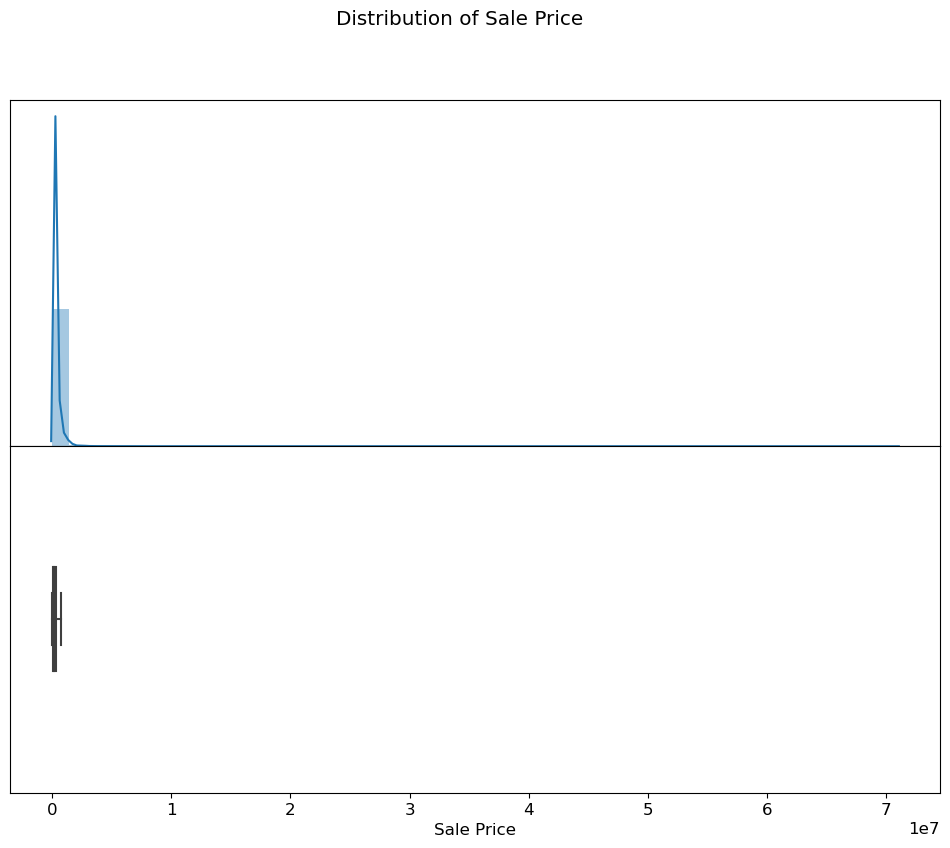

In [91]:
plot_distribution(training_data, label='Sale Price')

The visualization above has a scale that makes it difficult to analyze any pattens or significant points in the plot. With a scale that is not fit for this data, the data is crammed to the left side of the plot, which makes it not very useful. To overcome this, we will rescale the x-axis by making the minimum and maximum values of the axis closer to the true min and max values of the dataset.

In [92]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

New distribution plot on the log-transformed sale price.

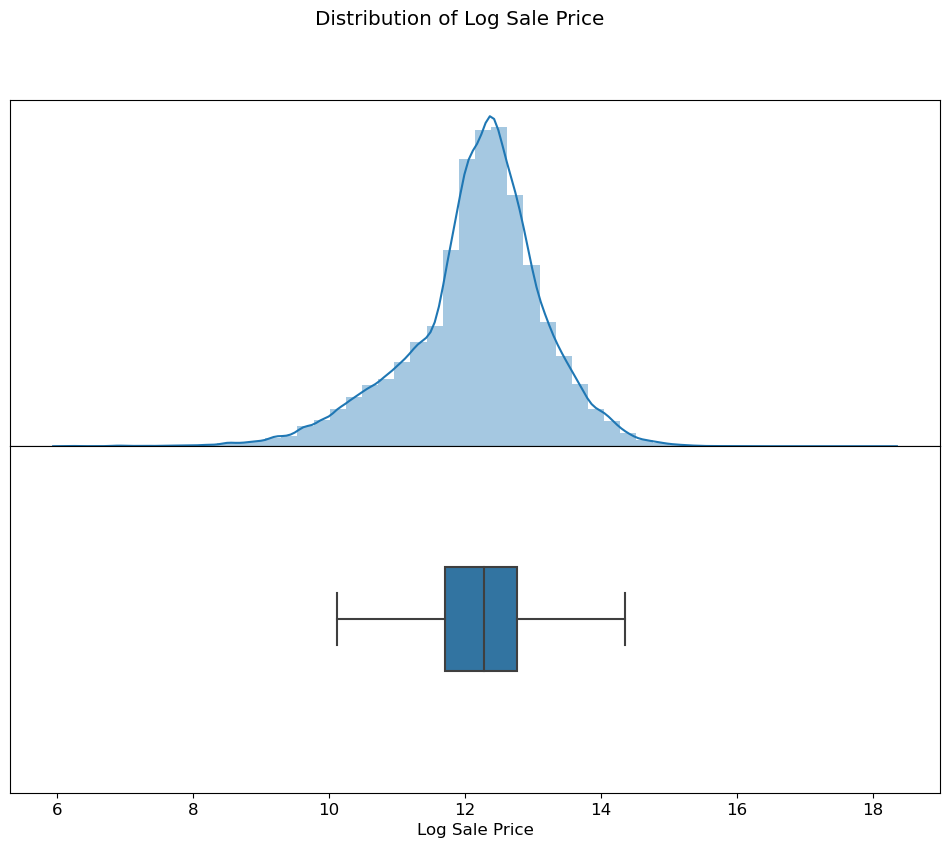

In [93]:
plot_distribution(training_data, label='Log Sale Price');

<br><br>

---
## Correlation between `Log Sale Price` and the total area occupied by the household, `Building Square Feet`.

Applying a log-transformation to the `Building Square Feet` column.


In [94]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

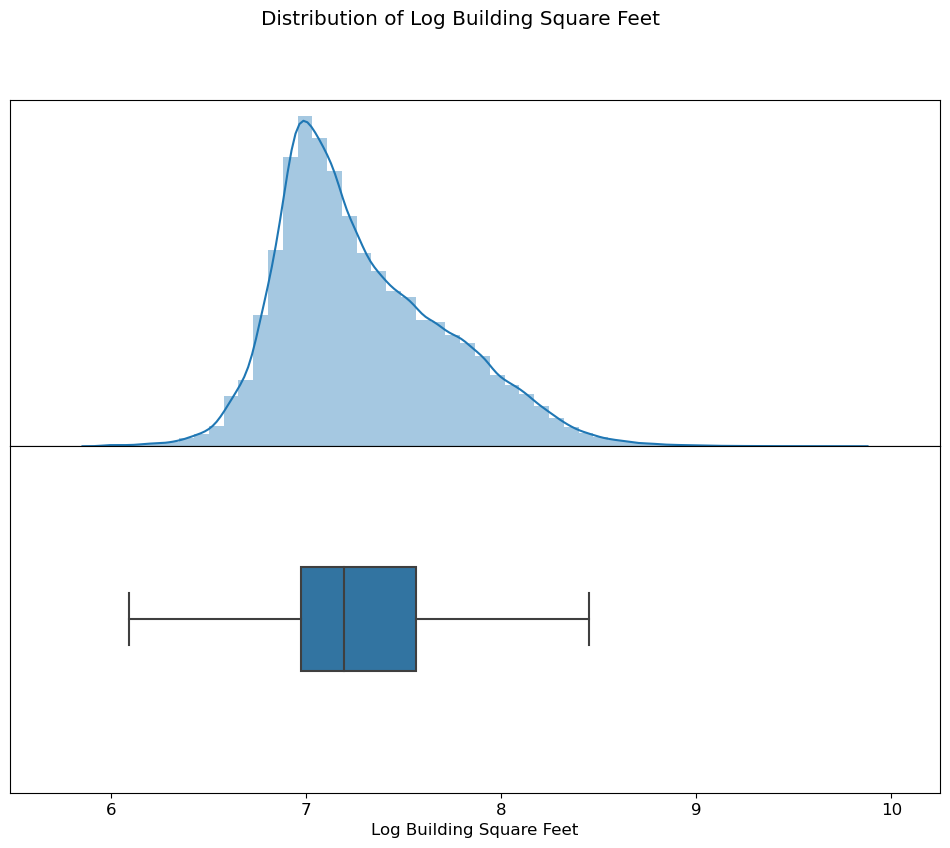

In [95]:
plot_distribution(training_data, label='Log Building Square Feet');

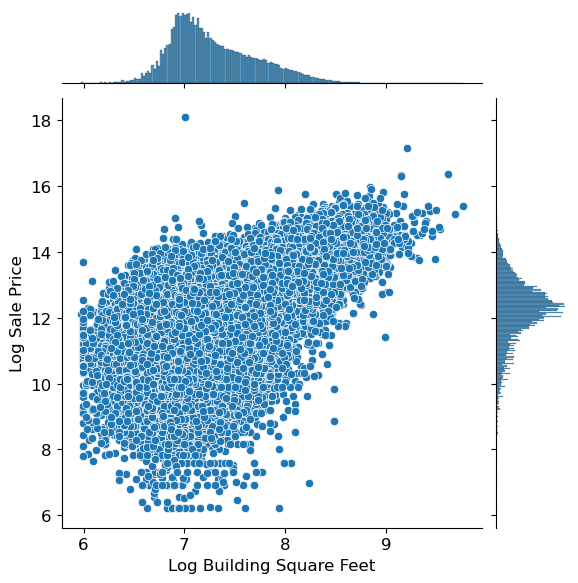

In [96]:
sns.jointplot(data=training_data, x="Log Building Square Feet", y="Log Sale Price")

I believe that Log Building Square Feet would make a good candidate as one of the features because from the plot, we can see that much of the data shows a positive linear correlation between the variables. The regression line has a positive slope and the data seems to be, for the most part, well represented by the line. However, we should also keep in mind, there are some outliers/low values in the bottom left of the graph, which are a bit further away. 




## Removing Outliers


In [97]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): table to be filtered
      variable (string): column with numerical outliers
      lower (numeric): remove observations with values lower than or equal
      upper (numeric): remove observations with values higher
    
    Output:
        DataFrame with outliers removed
    """  
    return data[(data[variable] > lower) & (data[variable] <= upper)]


# Feature Engineering

### Bedrooms

Extracting total number of bedrooms for the model.


In [98]:
def add_total_bedrooms(data):
    """
    Input:
      dataframe: DataFrame containing Description column.

    Output:
      Dataframe with a new column for # of "Bedrooms" 

    """
    with_rooms = data.copy()
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(r'(\d+) of which are bedrooms?').fillna(0).astype(int)
    return with_rooms

training_data = add_total_bedrooms(training_data)


---
Visualization for association between `Bedrooms` and `Log Sale Price`. 

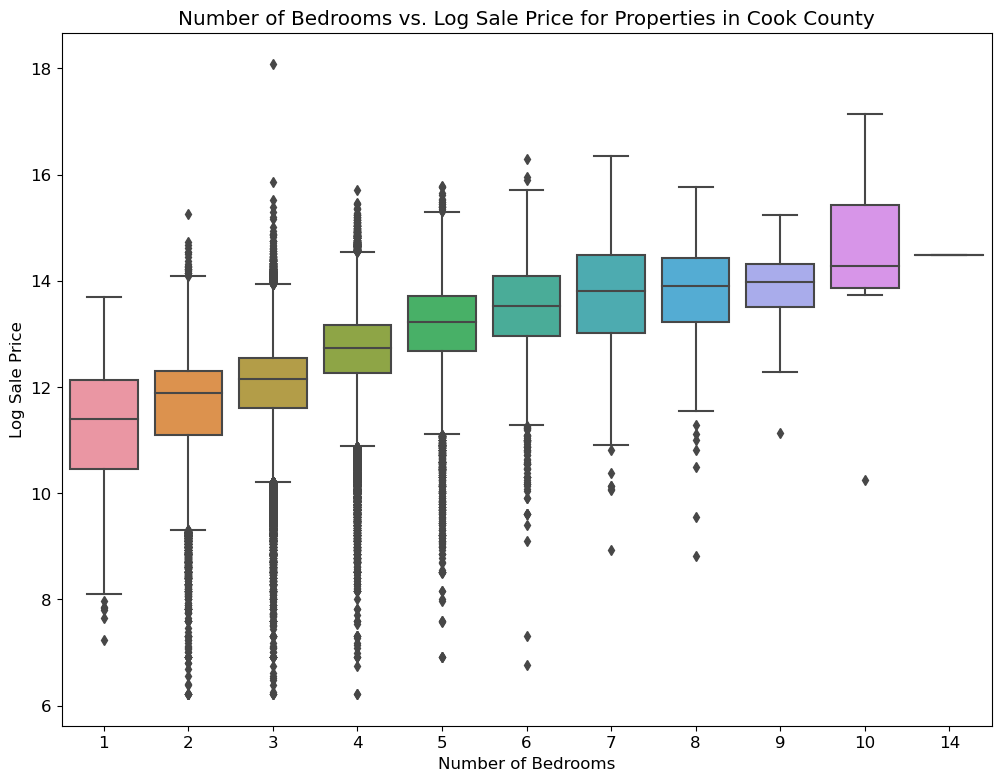

In [99]:
sns.boxplot(data=training_data, x='Bedrooms', y='Log Sale Price')
plt.xlabel('Number of Bedrooms')
plt.title('Number of Bedrooms vs. Log Sale Price for Properties in Cook County');

In [100]:
num_neighborhoods = len(training_data['Neighborhood Code'].unique())
num_neighborhoods

193



---
## Neighborhoods

In [101]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

Since there is a large number of neighborhoods, we use the top 20 most populated so that overplotting is avoided.

In [102]:
top_20_codes = training_data['Neighborhood Code'].value_counts().index[:20]
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20_codes)]

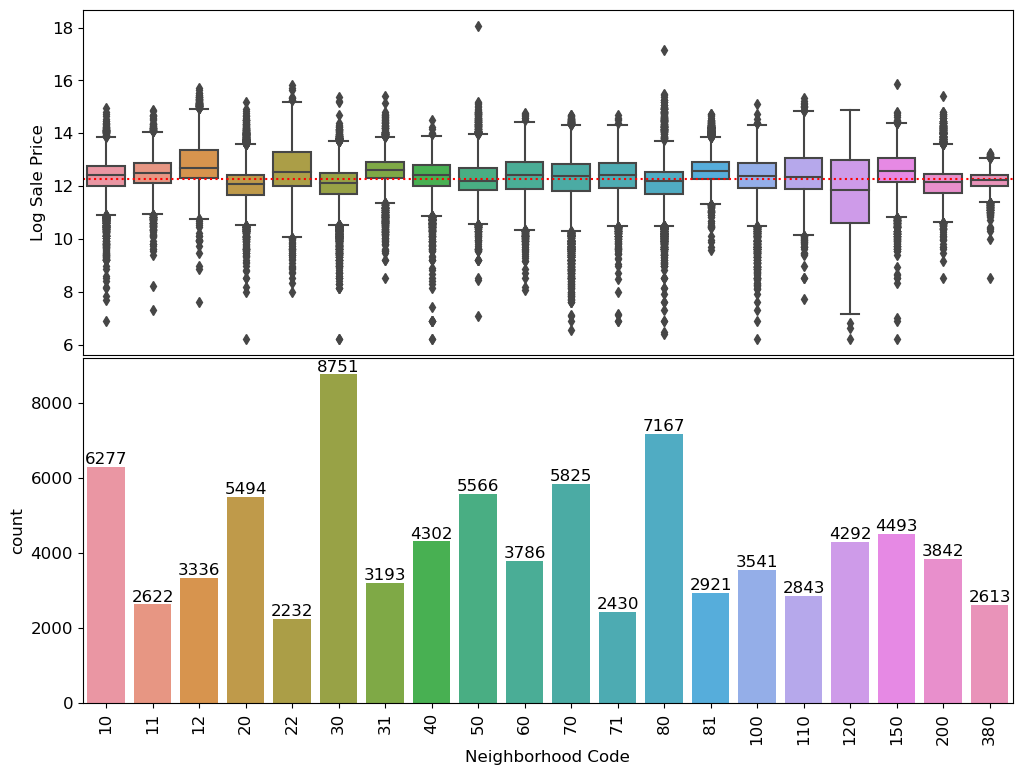

In [103]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)


---

We can see some issues that may cause problems/biases due to certain neighborhoods having more available data compared to others.
Since there is an imbalance of data between these neighborhoods, we will group by `Log Sale Price` and take the median, or other metric, to list expensive neighborhoods.


In [104]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data: data frame containing at least a string-valued 'Neighborhood Code'
        and numeric 'Log Sale Price' column
      n : int for the number of top values desired
      metric: function used for aggregating the data in each neighborhood.
    
    Output:
      a list of the neighborhood codes of the top n highest-priced neighborhoods based on metric
    """
    neighborhoods = data.loc[:,['Neighborhood Code', 'Log Sale Price']].groupby('Neighborhood Code').agg(metric).sort_values('Log Sale Price', ascending = False).index[:n]
    
    # Make sure the final list contains the generic int type used in Python3
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

---
Helper function to add new column to data frame for whether a property is within an expensive neighborhood(1) or not(0).

In [105]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

---
## Qualitative Data

The `Roof Material` column contains digits that correspond to the following:

Roof Material: 1-Shingle/Asphalt, 2-Tar&Gravel, 3-Slate, 4-Shake, 5-Tile, 6-Other


Function for replacing qualitative data with numerical representation for use in our model.

In [106]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.copy()
    roof_dict = {1: 'Shingle/Asphalt', 2: 'Tar&Gravel', 3: 'Slate', 4: 'Shake', 5: 'Tile', 6: 'Other'}
    data = data.replace({'Roof Material': roof_dict})
    return data
    
training_data = substitute_roof_material(training_data)
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


<br><br>

---
## Using One Hot Encoding


Use of Scikit-learn `OneHotEncoder` for performing OneHotEncoding on the roof material. Created a function for creating table with these values, better suited for use in predictive model.

In [107]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    category = ['Roof Material']
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[category])
    category_data = oh_enc.transform(data[category]).toarray()
    cat_df = pd.DataFrame(data = category_data, columns = oh_enc.get_feature_names_out(), index = data.index)
    return data.join(cat_df)

training_data_ohe = ohe_roof_material(training_data)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0
